### 1. Initialization

In [81]:
import pandas as pd, numpy as np, requests, time, csv, datetime, re, os
pd.set_option("max_rows", 100)

import xml.etree.ElementTree

from matplotlib import pyplot as plt

from scipy import stats

In [2]:
# function to keep lists of predictions, train numbers the same length
# useful for adding these lists to DataFrames

def toReadableTime(ts):
    return datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S').split()[1]
def toReadableDateTime(ts):
    return datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

def dayIncrement(readYear, readMonth, readDay):
    # 30-day months
    if readMonth in ["04","06","09","11"]:
        if readDay == "30":
            nextDate = readYear + "-" + str(int(readMonth) + 1).zfill(2) + "-01"
        elif int(readDay) > 30:
            print("INVALID DATE")
            nextDate = "INVALID DATE"
        else:
            nextDate = readYear + "-" + readMonth + "-" + str(int(readDay) + 1).zfill(2)
    # 31-day months
    elif readMonth in ["01","03","05","07","08","10"]:
        if readDay == "31":
            nextDate = readYear + "-" + str(int(readMonth) + 1).zfill(2) + "-01"
        elif int(readDay) > 31:
            print("INVALID DATE")
            nextDate = "INVALID DATE"
        else:
            nextDate = readYear + "-" + readMonth + "-" + str(int(readDay) + 1).zfill(2)
    # December
    elif readMonth == "12":
        if readDay == "31":
            nextDate = str(int(readYear) + 1) + "-" + "01-01"
        elif int(readDay) > 31:
            print("INVALID DATE")
            nextDate = "INVALID DATE"
        else:
            nextDate = readYear + "-" + readMonth + "-" + str(int(readDay) + 1).zfill(2)
    # February
    elif readMonth == "02":
        if int(readYear) % 4 != 0:
            if readDay == "28":
                nextDate = readYear + "-" + str(int(readMonth) + 1).zfill(2) + "-01"
            elif int(readDay) > 31:
                print("INVALID DATE")
                nextDate = "INVALID DATE"
            else:
                nextDate = readYear + "-" + readMonth + "-" + str(int(readDay) + 1).zfill(2)
        else:
            if readDay == "29":
                nextDate = readYear + "-" + str(int(readMonth) + 1).zfill(2) + "-01"
            elif int(readDay) > 31:
                print("INVALID DATE")
                nextDate = "INVALID DATE"
            else:
                nextDate = readYear + "-" + readMonth + "-" + str(int(readDay) + 1).zfill(2)
    else:
        pass
    return nextDate

def consist_to_four_digit(consist):
    if pd.isnull(consist) == False and len(str(consist))>0:
        if type(consist) == str:
            consist = int(consist)
            if consist >= 1 and consist <= 400:
                fourdigitconsist = consist + 1199
            elif consist >= 501 and consist <= 999:
                fourdigitconsist = consist + 1499
            else:
                fourdigitconsist = int(consist)

        else:
            consist = int(consist)
            if consist >= 1 and consist <= 400:
                fourdigitconsist = consist + 1199
            elif consist >= 501 and consist <= 999:
                fourdigitconsist = consist + 1499
            else:
                fourdigitconsist = int(consist)
    else:
        fourdigitconsist = np.NaN
    return fourdigitconsist

def loadSMC(day2read):
    # getfile = "http://nbsnap/atcslogs/SmcSls/%sSLS.smc" % str(datetime.datetime.today()).split()[0].replace("-","")[2:]
    # day2read should be in the format YYYY-MM-DD
    
    readYear = day2read.split("-")[0]
    readMonth= day2read.split("-")[1]
    readDay= day2read.split("-")[2]
    
    #getfile = "http://nbsnap/atcslogs/SmcSls/{}SLS.smc".format((readYear[2:]+readMonth+readDay))
    getfile = "{}SLS.smc".format((readYear[2:]+readMonth+readDay))
    
    readMsg = "Running for {}-{}-{}".format(readYear, readMonth, readDay)
    print(readMsg)
    s = requests.get(getfile)
    print(s)
    
    smc = s.text
    smcrecords = smc.replace("\n","").split("\r")
    
    # remove records we don't want, so future operations are faster
    poplist = []
    couples = []

    print(len(smcrecords), "initial records")

    for i in range(len(smcrecords)):
        rec = smcrecords[i].replace("{", "").replace("}","").split()

        if "Arrived" in rec and "Destination" in rec and "Platform" in rec:
            pass
        elif "Vehicle" in rec and "IDs" in rec:
            couples.append(smcrecords[i])
            poplist.append(i)
        else:    
            poplist.append(i)

    for item in reversed(poplist):
        smcrecords.pop(item)

    print(len(smcrecords), "arrival records")
    
    smcrecords = smc.replace("\n","").split("\r")
    
    coupleDict = {}

    for couple in couples:

        info = couple.replace("{", "").replace("}","").split()

        veh1 = consist_to_four_digit(info[6])
        veh2 = consist_to_four_digit(info[7])

        coupleDict[veh1] = veh2
        
    # remove records we don't want, so future operations are faster
    poplist = []
    couples = []

    for i in range(len(smcrecords)):
        rec = smcrecords[i].replace("{", "").replace("}","").split()

        if "Arrived" in rec and "Destination" in rec and "Platform" in rec:
            pass
        elif "Vehicle" in rec and "IDs" in rec:
            couples.append(smcrecords[i])
            poplist.append(i)
        else:    
            poplist.append(i)

    for item in reversed(poplist):
        smcrecords.pop(item)
        
    dfs = []

    for record in smcrecords:
        rec = [x.replace("{","").replace("}","") for x in record.split(" ",2)]
        dfs.append(pd.DataFrame([rec], columns=["TIME", "SRS_ID", "MSG"]))

    smcdf = pd.concat(dfs, ignore_index=True)

    smcdf["CONSIST"] = [re.sub("\D", "", x.lower().split()[x.lower().split().index('consist')+1]) if "consist" in x.lower().split() else '' for x in smcdf['MSG']]

    smcdf["FOUR_DIGIT_CONSIST"] = [consist_to_four_digit(x) for x in smcdf['CONSIST']]
    smcdf["PLATFORM"] = [x.split()[x.split().index("Platform")+1] for x in smcdf["MSG"]]
    
    smcdf["H"] = [int(x.split(":")[0]) for x in smcdf["TIME"]]
    dayChangeIdx = smcdf[smcdf["H"].diff() < 0].index[0]
    smcdf.drop("H", axis=1, inplace=True)
    
    smcdf["DAY"] = np.NaN
    smcdf.loc[:(dayChangeIdx-1), "DAY"] = day2read
    smcdf.loc[dayChangeIdx:, "DAY"] = dayIncrement(readYear=readYear, readMonth=readMonth, readDay=readDay)
    
    smcdf["DATETIME"] = smcdf["DAY"] + " " + smcdf["TIME"]
    
    
    #smcdf["DATETIME"] = [pd.to_datetime("2019-01-16 " +x) for x in smcdf["TIME"]]
    smcdf["UNIX"] = [(time.mktime(time.strptime(str(x).split(".")[0], "%Y-%m-%d %H:%M:%S"))) for x in smcdf["DATETIME"]]
    
    return smcdf, coupleDict

def generateUniqueId(uid_no):
    return str(datetime.datetime.today()).split()[0] + "--" + str(uid_no)

## Steps


0. Initialization
1. Load NextBus data
2. Load ATCS arrival data
3. Load ATCS signs data
4. Match NB 2 ATCS
5. Match ATCS 2 NB
6. Report

### 2. Load NextBus Data

This steps loads all data collected from NextBus API into memory as a Pandas DataFrame. The data is then filtered to only contrain observations where the next arriving vehicle is predicted to arrive within ten minutes.

In [3]:
filepath = "NB-VNR-2019-01-16.csv"

data = pd.read_csv(filepath)
sample = data.query("Seconds < 600")

In [9]:
%%time

vehicles = list(data["Vehicle"].unique())

print(len(vehicles), "unique vehicles.")

arrivals = pd.DataFrame(columns=["Timestamp", "Line", "Vehicle", "Seconds", "Diff", "Cut-Off", "UID"])

uid_no = 1
for vehicle in vehicles:
    
    testtrain = data[data["Vehicle"] == vehicle]
    testtrain["Diff"] = testtrain["Timestamp"].diff()
    testtrain["Cut-Off"] = testtrain["Diff"] >= (45*60)
    o = 0
    #print(vehicle, "-", len(list(testtrain[testtrain["Cut-Off"]].index)))
    for i in list(testtrain[testtrain["Cut-Off"]].index) + [testtrain.index.max()]:
        #unique_train = generateUniqueId(uid_no)
        unique_train = "UID-"+str(uid_no)
        #print(unique_train)
        #print(testtrain.loc[o:i-1])

        try:
            #ii = testtrain["Seconds"].loc[o:i-1].idxmin()
            ii = testtrain["Seconds"].loc[o:i].idxmin()
            values = list(testtrain.loc[ii]) + [unique_train]
            #print(values)
            
            df2 = pd.DataFrame([values], columns=["Timestamp", "Line", "Vehicle", "Seconds", "Diff", "Cut-Off", "UID"])
            arrivals = arrivals.append(df2, ignore_index=True)
            
        except:
            pass
            #print(vehicle)
        uid_no += 1
        o = i
arrivals = arrivals.sort_values("Timestamp")[["Timestamp", "Line", "Vehicle", "Seconds", "UID"]].reset_index(drop=True)

print(arrivals["UID"].nunique(), "unique arrival IDs")

arrivals["Arrival Timestamp"] = arrivals["Timestamp"] + arrivals["Seconds"]
arrivals["Arrival Time"] = [toReadableTime(x) for x in arrivals["Arrival Timestamp"]]

141 unique vehicles.


/Users/mapsense-simon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/mapsense-simon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


487 unique arrival IDs
CPU times: user 19 s, sys: 102 ms, total: 19.1 s
Wall time: 19.6 s


### 3. Load ATCS Arrival Data

In [32]:
%%time

smcobject = open("190116SLS.smc", "r")
smclist = []


for x in smcobject:
    smclist.append(x)

smcrecords = [x.replace("\n", "").strip() for x in smclist]

del smclist

CPU times: user 444 ms, sys: 45.7 ms, total: 490 ms
Wall time: 506 ms


In [33]:
day2read = "2019-01-16"
readYear = day2read.split("-")[0]
readMonth= day2read.split("-")[1]
readDay= day2read.split("-")[2]


# remove records we don't want, so future operations are faster
poplist = []
couples = []

print(len(smcrecords), "initial records")

for i in range(len(smcrecords)):
    rec = smcrecords[i].replace("{", "").replace("}","").split()

    if "Arrived" in rec and "Destination" in rec and "Platform" in rec:
        pass
    elif "Vehicle" in rec and "IDs" in rec:
        couples.append(smcrecords[i])
        poplist.append(i)
    else:    
        poplist.append(i)

for item in reversed(poplist):
    smcrecords.pop(item)

print(len(smcrecords), "arrival records")

smcobject = open("190116SLS.smc", "r")
smclist = []


for x in smcobject:
    smclist.append(x)

smcrecords = [x.replace("\n", "").strip() for x in smclist]

del smclist

coupleDict = {}

for couple in couples:

    info = couple.replace("{", "").replace("}","").split()

    veh1 = consist_to_four_digit(info[6])
    veh2 = consist_to_four_digit(info[7])

    coupleDict[veh1] = veh2

# remove records we don't want, so future operations are faster
poplist = []
couples = []

for i in range(len(smcrecords)):
    rec = smcrecords[i].replace("{", "").replace("}","").split()

    if "Arrived" in rec and "Destination" in rec and "Platform" in rec:
        pass
    elif "Vehicle" in rec and "IDs" in rec:
        couples.append(smcrecords[i])
        poplist.append(i)
    else:    
        poplist.append(i)

for item in reversed(poplist):
    smcrecords.pop(item)

dfs = []

for record in smcrecords:
    rec = [x.replace("{","").replace("}","") for x in record.split(" ",2)]
    dfs.append(pd.DataFrame([rec], columns=["TIME", "SRS_ID", "MSG"]))

smcdf = pd.concat(dfs, ignore_index=True)

smcdf["CONSIST"] = [re.sub("\D", "", x.lower().split()[x.lower().split().index('consist')+1]) if "consist" in x.lower().split() else '' for x in smcdf['MSG']]

smcdf["FOUR_DIGIT_CONSIST"] = [consist_to_four_digit(x) for x in smcdf['CONSIST']]
smcdf["PLATFORM"] = [x.split()[x.split().index("Platform")+1] for x in smcdf["MSG"]]

smcdf["H"] = [int(x.split(":")[0]) for x in smcdf["TIME"]]
dayChangeIdx = smcdf[smcdf["H"].diff() < 0].index[0]
smcdf.drop("H", axis=1, inplace=True)

smcdf["DAY"] = np.NaN
smcdf.loc[:(dayChangeIdx-1), "DAY"] = day2read
smcdf.loc[dayChangeIdx:, "DAY"] = dayIncrement(readYear=readYear, readMonth=readMonth, readDay=readDay)

smcdf["DATETIME"] = smcdf["DAY"] + " " + smcdf["TIME"]


#smcdf["DATETIME"] = [pd.to_datetime("2019-01-16 " +x) for x in smcdf["TIME"]]
smcdf["UNIX"] = [(time.mktime(time.strptime(str(x).split(".")[0], "%Y-%m-%d %H:%M:%S"))) for x in smcdf["DATETIME"]]


505369 initial records
8497 arrival records


In [34]:
smc = smcdf
coupleDict = {}

for couple in couples:

    info = couple.replace("{", "").replace("}","").split()

    veh1 = consist_to_four_digit(info[6])
    veh2 = consist_to_four_digit(info[7])

    coupleDict[veh1] = veh2

In [35]:
vnr = smc[smc["PLATFORM"] == "VNR"].reset_index(drop=True)

vnr = vnr[["DATETIME","TIME", "UNIX", "FOUR_DIGIT_CONSIST"]]
vnr["SECOND_CONSIST"] = [coupleDict[x] for x in vnr["FOUR_DIGIT_CONSIST"]]
print(len(vnr), "arrivals at VNR")

t_min = data['Timestamp'].min() - 360
t_max = data["Timestamp"].max() + 360

vnr_t = vnr[(vnr["UNIX"] > t_min) & (vnr["UNIX"] < t_max)]
print(len(vnr_t), "arrivals at VNR within timeframe")

541 arrivals at VNR
388 arrivals at VNR within timeframe


### 4. Load ATCS Sign Data

In [10]:
signcodes = [
    ["8","J","OB"],
    ["9","J","OB"],
    ["10","J","OB"],
    ["11","J","OB"],
    ["12","J","OB"],
    ["13","J","OB"],
    ["14","J","IB"],
    ["15","J","IB"],
    ["30","K","OB"],
    ["32","K","OB"],
    ["33","K","IB"],
    ["38","K","OB"],
    ["55", "L", "OB"],
    ["56","L","OB"],
    ["57","L", "OB"],
    ["58","L","OB"],
    ["60", "L","OB"],
    ["61","L","IB"],
    ["62","L","IB"],
    ["77","M","OB"],
    ["80","M","OB"],
    ["81","M","IB"],
    ['82',"M","IB"],
    ["87","M","OB"],
    ["91","M","OB"],
    ["100","N","OB"],
    ["103","N","OB"],
    ["107","N","IB"],
    ["108","N","OB"],
    ["109","N","IB"],
    ["115","N","IB"],
    ["119","N","OB"],
    ["124","N","OB"],
    ["153","T","OB"],
    ["161","T","IB"],
    ["169","T","IB"],
    ["175","T","IB"],
    ["134","S","OB"],
    ["135","S","OB"],
    ["136","S","IB"],
    ["215","S","IB"],
    ["218","S","OB"],
    ["137","S","IB"],
    ["227","X",np.NaN]
]

signcodesDF = pd.DataFrame(data=signcodes, columns=["SIGN CODE", "LINE", "DIRECTION"])

In [11]:
%%time

smcobject = open("190116SLS.smc", "r")
smclist = []


for x in smcobject:
    smclist.append(x)

smcrecords = [x.replace("\n", "").strip() for x in smclist]

CPU times: user 420 ms, sys: 58.5 ms, total: 478 ms
Wall time: 500 ms


In [14]:
%%time



consist2signList = []

for rec in smcrecords:
    rec = rec.replace("{","").replace("}","")
    rectime = rec.split(" ")[0]
    if "Sign" in rec:
        try:
            consist = rec.split()[rec.split().index("Consist")+1]
            if "Sign" in rec.split():
                sign = rec.split()[rec.split().index("Sign")+3]
            elif "Signs" in rec.split():
                sign = rec.split()[rec.split().index("Signs")+1]
            else:
                pass

            consist2signList.append(pd.DataFrame(data=[[rectime, consist_to_four_digit(consist), sign]], columns=["TIME","CONSIST", "SIGN CODE"]))
        except ValueError:
            pass
    else:
        pass
#consist2sign = pd.concat(consist2signList, ignore_index=True).drop_duplicates(subset=["CONSIST"], keep="last").merge(signcodesDF, on="SIGN CODE")
test = pd.concat(consist2signList, ignore_index=True)

day2read = "2019-01-16"
readYear = "2019"
readMonth = "01"
readDay = "16"

test["H"] = [int(x.split(":")[0]) for x in test["TIME"]]
dayChangeIdx = test[test["H"].diff() < 0].index[0]
test.drop("H", axis=1, inplace=True)

test["DAY"] = np.NaN
test.loc[:(dayChangeIdx-1), "DAY"] = day2read
test.loc[dayChangeIdx:, "DAY"] = dayIncrement(readYear=readYear, readMonth=readMonth, readDay=readDay)



test["DATETIME"] = test["DAY"] + " " + test["TIME"]

test.drop(["DAY", "TIME"], axis=1, inplace=True)

# remove sign codes that are not found in the reference
test = test[test["SIGN CODE"].isin(signcodesDF["SIGN CODE"].unique())]

# drop duplicate entries
test = test.drop_duplicates(subset=["CONSIST", "DATETIME", "SIGN CODE"])
test["UNIX"] = [(time.mktime(time.strptime(str(x).split(".")[0], "%Y-%m-%d %H:%M:%S"))) for x in test["DATETIME"]]

signs2consists = test.merge(signcodesDF, on="SIGN CODE")

CPU times: user 32.9 s, sys: 773 ms, total: 33.7 s
Wall time: 37 s


### 5. Match NextBus to ATCS

In [22]:
matchCodes = {
    1 : "MATCHED ON VEHICLE ID",
    2 : "GHOST TRAIN; NO UN-MATCHED ARRIVALS",
    3 : "ONE REMAINING MATCH; SAME LINE",
    4 : "MATCHED TO OUT-OF-SERVICE TRAIN",
    5 : "ONE REMAINING MATCH; DIFFERENT LINES",
    6 : "UNMATCHED-UNKNOWN; MULTIPLE OUT-OF-SERVICE TRAINS",
    7 : "MATCHED; ONE UN-MATCHED RECORD HAS SAME LINE",
    8 : "UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW",
    9 : "GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW",
    10 : "UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES"
}

matchDescriptions = {
    "MATCHED ON VEHICLE ID" : "The vehicle ID is present in both the NextBus and ATCS datasets within the given time window.",
    "GHOST TRAIN; NO UN-MATCHED ARRIVALS" : "There are no un-matched arrivals in the ATCS dataset within the given time window",
    "ONE REMAINING MATCH; SAME LINE" : "There is one remaining un-matched arrival in the ATCS dataset within the given time window, and it is the same line as the NextBus arrival.",
    "MATCHED TO OUT-OF-SERVICE TRAIN" : "There is one remaining un-matched arrival in the ATCS dataset within the given time window, and it shown as an out-of-service train.",
    "ONE REMAINING MATCH; DIFFERENT LINES" : "There is one remaining un-matched arrival in the ATCS dataset within the given time window, and it is a different line than the NextBus arrival.",
    "UNMATCHED-UNKNOWN; MULTIPLE OUT-OF-SERVICE TRAINS" : "There are multiple remaining un-matched arrivals in the ATCS dataset within the given time window, and they are shown as out-of-service trains",
    "MATCHED; ONE UN-MATCHED RECORD HAS SAME LINE" : "There is one remaining un-matched arrival in the ATCS dataset within the given time window, and it is the same line as the NextBus arrival.",
    "UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW" : "There are multiple remaining un-matched arrivals in the ATCS dataset within the given time window, and more than one is the same line as the NextBus arrival",
    "GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW" : "There are no ATCS arrivals within the given time window.",
    "UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES" : "There are multiple remaining un-matched arrivals in the ATCS dataset within the given time window, and they are different lines than the NextBus arrival."
}

In [29]:
unmatchedATCSarrivals.drop(0, axis=0, inplace=True)

/Users/mapsense-simon/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [107]:
%%time

matchTimeDif = []

unmatchedNBarrivals = arrivals[arrivals["Seconds"] <= 60].copy(deep=True)
unmatchedATCSarrivals = vnr_t.copy(deep=True)

#matchedNBidx = []
matchedATCSidx = []

arrivalMatchingCols = ["NextBus Vehicle ID", "NextBus Arrival Time", "Match Code", "Match Code Description"]
arrivalMatching = pd.DataFrame(columns=arrivalMatchingCols)


numArrivals = len(arrivals[arrivals["Seconds"] <= 60].index)
matches = 0
confirmedGhosts = 0
matchedViaRemovalLine = 0

timeRadius = 180

for i in arrivals[arrivals["Seconds"] <= 60].index:
    # generate time window
    arrivalTime = arrivals.loc[i, "Timestamp"]
    arrivalVehID = arrivals.loc[i, "Vehicle"]
    arrivalLine = arrivals.loc[i, "Line"]
    t_max = arrivalTime + timeRadius
    t_min = arrivalTime - timeRadius
    
    # generate DFs of only arrivals within the time window
    searchDFarrivals = unmatchedATCSarrivals[(unmatchedATCSarrivals["UNIX"] < t_max) & (unmatchedATCSarrivals["UNIX"] > t_min)]
    arrivalDFarrivals = arrivals[(arrivals["Timestamp"] < t_max) & (arrivals["Timestamp"] > t_min)]
    
    # ASSIGN LINE INFORMATION TO ATCS LOGS
    if len(searchDFarrivals) > 0:
        
        dfs = []

        for m in searchDFarrivals.index:
            car1 = searchDFarrivals.loc[m, "FOUR_DIGIT_CONSIST"]
            unix = searchDFarrivals.loc[m, "UNIX"]

            #print(car1, car2)

            tempDF = signs2consists[(signs2consists["CONSIST"].isin([car1])) & (signs2consists["UNIX"] <= unix) & (signs2consists["UNIX"] >= (unix - (60*60)))].sort_values("UNIX")

            if len(tempDF) == 0:
                line = "X"
            else:
                line = tempDF.loc[tempDF["UNIX"].idxmax(), "LINE"]
            dfs.append(pd.DataFrame([[car1, line]], columns=["FOUR_DIGIT_CONSIST", "LINE"]))

        try:
            lineAssignments = pd.concat(dfs, ignore_index=True)
        except ValueError:
            print(len(searchDFarrivals))

        searchDFarrivals = searchDFarrivals.merge(lineAssignments, on="FOUR_DIGIT_CONSIST")

        # OK, now that the arrivals dataset (NB) is loaded and subset, and the search dataset (ATCS) is both subset and has lines assigned
        # we can proceed
        
        
        
        if arrivalVehID in list(searchDFarrivals["FOUR_DIGIT_CONSIST"]):
            
            # OPTION 1 -- MATCHED ON VEHICLE ID 
            # the vehicle ID is present in both datasets, thereby allowing us to make the match.
            # This NextBus arrival is therefore considered to be MATCHED.
            matchCodeID = 1
            matches += 1
            #matchedNBidx.append(i)
            unmatchedNBarrivals.drop(i, axis=0, inplace=True)
            
            sdf_idx = list(searchDFarrivals["FOUR_DIGIT_CONSIST"]).index(arrivalVehID)
            datetime_value = searchDFarrivals["DATETIME"][sdf_idx]
            atcs_idx = unmatchedATCSarrivals[(unmatchedATCSarrivals["DATETIME"] == datetime_value) & (unmatchedATCSarrivals["FOUR_DIGIT_CONSIST"] == arrivalVehID)].index[0]
            
            matchTimeDif.append(arrivalTime-unmatchedATCSarrivals.loc[atcs_idx, "UNIX"])
            
            unmatchedATCSarrivals.drop(atcs_idx, axis=0, inplace=True)
            
            
        elif arrivalVehID in list(searchDFarrivals["SECOND_CONSIST"]):
            
            # OPTION 1 -- MATCHED ON VEHICLE ID 
            # the vehicle ID is present in both datasets, thereby allowing us to make the match.
            # This NextBus arrival is therefore considered to be MATCHED.
            matchCodeID = 1
            matches += 1
            #matchedNBidx.append(i)
            unmatchedNBarrivals.drop(i, axis=0, inplace=True)
            
            sdf_idx = list(searchDFarrivals["SECOND_CONSIST"]).index(arrivalVehID)
            datetime_value = searchDFarrivals["DATETIME"][sdf_idx]
            atcs_idx = unmatchedATCSarrivals[(unmatchedATCSarrivals["DATETIME"] == datetime_value) & (unmatchedATCSarrivals["SECOND_CONSIST"] == arrivalVehID)].index[0]
            
            matchTimeDif.append(arrivalTime -unmatchedATCSarrivals.loc[atcs_idx, "UNIX"])
            
            unmatchedATCSarrivals.drop(atcs_idx, axis=0, inplace=True)
            
            
        # If the vehicle ID is not found in the search dataset, we can take several actions.    
        else:
            
            # create an array of vehicle IDs that are present in both the substs of the arrivals dataset and the search dataset.
            # these records can be considered to be MATCHED, thereby removing them from our consideration
            otherMatches = []
            for veh in arrivalDFarrivals["Vehicle"].unique():

                if veh in list(searchDFarrivals["FOUR_DIGIT_CONSIST"]):
                    otherMatches.append(veh)
                elif veh in list(searchDFarrivals["SECOND_CONSIST"]):
                    otherMatches.append(veh)
                else:
                    pass
            
            # the resultant DF is all of the arrivals within the subset search dataset for which there are no matching vehicle
            # ID matches in the subset arrivals dataset
            
            searchArrivals = searchDFarrivals[searchDFarrivals["FOUR_DIGIT_CONSIST"].isin(otherMatches) == False]
            
            
            if len(searchArrivals) == 0:
                
                # OPTION 2 -- GHOST TRAIN; NO UN-MATCHED ARRIVALS
                # there are no un-matched arrivals in the subset search dataset
                # This NextBus arrival is therefore considered to be a GHOST TRAIN.
                matchCodeID = 2
                confirmedGhosts += 1
                print(arrivalVehID, "GHOST TRAIN -- no remaining, un-matched arrival in time window.")
            
            # if there is only one train in the remaining, un-matched subset of the search dataset, a number of outcomes can occur 
            elif len(searchArrivals) == 1:
                
                
                if arrivalLine == searchArrivals.iloc[0]["LINE"]:
                    
                    # OPTION 3 -- ONE REMAINING MATCH; SAME LINES
                    # the remaining, un-matched train in the subset search dataset is of the same line as the NextBus
                    # arrival being investigated, thereby allowing us to assert that the NextBus arrival matches this lone remaining
                    # un-matched ATCS arrival This NextBus arrival is therefore considered to be MATCHED.
                    
                    print(arrivalVehID, "MATCHED -- Matched via removal & line.")
                    matchCodeID = 3
                    matches += 1
                    matchedViaRemovalLine += 1
                    #matchedNBidx.append(i)
                    unmatchedNBarrivals.drop(i, axis=0, inplace=True)
                    
                    sdf_idx = 0
                    datetime_value = searchArrivals["DATETIME"][sdf_idx]
                    atcs_idx = unmatchedATCSarrivals[(unmatchedATCSarrivals["DATETIME"] == datetime_value)].index[0]
                    unmatchedATCSarrivals.drop(atcs_idx, axis=0, inplace=True)
                
                elif searchArrivals.iloc[0]["LINE"] == "X":
                    
                    # OPTION 4 -- MATCHED TO OUT-OF-SERVICE TRAIN
                    # the remaining, un-matched train in the subset search dataset is of line "X", which indicates 
                    # an out of service train. Because this is the only matching train within the time window and it does not contain 
                    # any information that would conflict with the information about the NextBus arrival, we are able to assert that 
                    # the NextBus arrival matches this train that the train control system considers to be out-of-service.
                    
                    matchCodeID = 4
                    print(arrivalVehID, "MATCHED -- Only eligible match is an out of service train")
                    #matchedNBidx.append(i)
                    unmatchedNBarrivals.drop(i, axis=0, inplace=True)
                    
                    sdf_idx = 0
                    datetime_value = searchArrivals["DATETIME"][sdf_idx]
                    atcs_idx = unmatchedATCSarrivals[(unmatchedATCSarrivals["DATETIME"] == datetime_value)].index[0]
                    unmatchedATCSarrivals.drop(atcs_idx, axis=0, inplace=True)
                    
                else:
                    
                    # OPTION 5 -- ONE REMAINING MATCH; DIFFERENT LINES 
                    # the remaining, un-matched train in the subset search dataset is of a different line than the line of 
                    # the NextBus arrival being investigated.
                    
                    matchCodeID = 5
                    print(arrivalVehID, "One remaining match; mismatched lines:", arrivalLine, "vs.", searchArrivals.iloc[0]["LINE"])
    
            
            # if there is more than one remaining, un-matched arrival record in the subset search dataset, there are a number of
            # steps we can take to try to match those search dataset records with the NextBus record we're investigating
            
            elif len(searchArrivals) > 1:
                try:
                    # count the number of times the line of the NextBus arrival appears in the un-matched subset search DataFrame
                    obs = dict(searchDFarrivals['LINE'].value_counts())[arrivalLine]
                    
                except KeyError:
                    # if the line of the NextBus arrival being investigated is not present in the subset search arrival records
                    # we first try to determine if there is a train considered to be out-of-service present
                    try:
                        if dict(searchDFarrivals['LINE'].value_counts())["X"] == 1:
                            
                            # OPTION 4 -- MATCHED TO AN OUT-OF-SERVICE TRAIN
                            # if there are no arrival records from the un-matched, subset search dataset that match the line of the 
                            # NextBus arrival being investigated, but there is one out-of-service train in that subset, we can match
                            # that out-of-service train to the NextBus arrival. This NextBus arrival is therefore considered to be MATCHED.
                            
                            matchCodeID = 4
                            obs = 0
                            print(arrivalVehID, "MATCHED -- MATCHED TO A OUT-OF-SERVICE TRAIN")
                            #matchedNBidx.append(i)
                            unmatchedNBarrivals.drop(i, axis=0, inplace=True)
                            
                            sdf_idx = list(searchDFarrivals["SECOND_CONSIST"]).index(arrivalVehID)
                            datetime_value = searchDFarrivals["DATETIME"][sdf_idx]
                            atcs_idx = unmatchedATCSarrivals[(unmatchedATCSarrivals["DATETIME"] == datetime_value) & (unmatchedATCSarrivals["SECOND_CONSIST"] == arrivalVehID)].index[0]
                            unmatchedATCSarrivals.drop(atcs_idx, axis=0, inplace=True)
                            
                        elif dict(searchDFarrivals['LINE'].value_counts())["X"] > 1:
                            
                            # OPTION 6 -- UNMATCHED-UNKNOWN; MULTIPLE OUT-OF-SERVICE TRAINS
                            # if there are no arrival records from the un-matched, subset search dataset that match the line of the 
                            # NextBus arrival being investigated, but there is more than one out-of-service trains in that subset, we are
                            # unable to make a match across datasets. This NextBus arrival is therefore considered to be UNMATCHED-UNKNOWN.
                            
                            matchCodeID = 6
                            obs = 0
                            print(arrivalVehID, "UNMATCHED-UNKNOWN -- multiple out-of-service trains")
                            
                        else:
                            
                            # this scenario is impossible; if there are 0 records with line "X", the above IF statement will throw
                            # a KeyError
                            pass
                        
                    except KeyError:
                        obs = 0
                        
                        # OPTION 10 -- UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES
                        # of the remaining, un-matched records, there are multiple records belonging to other lines
                        # than the line indidicated in the NextBus data
                        
                        matchCodeID = 10
                        print(arrivalVehID, "UNMATCHED-UNKNOWN - No records of NextBus line or out-of-service trains. Multiple records of other lines.")
                
                if obs == 1:
                    
                    # OPTION 7 -- MATCHED; ONE UN-MATCHED RECORD HAS SAME LINE
                    # of the remaining, un-matched records from the subset search dataset, only one belongs to the same
                    # line as the NextBus arrival being investigated, which allows us to match the NextBus arrival to that search 
                    # record. This NextBus arrival is therefore considered to be MATCHED.
                    
                    matchCodeID = 7
                    print(arrivalVehID, "MATCHED --  via removal & line (only one match with predicted line.)")
                    matches += 1
                    #matchedNBidx.append(i)
                    unmatchedNBarrivals.drop(i, axis=0, inplace=True)
                    
                    sdf_idx = list(searchDFarrivals["SECOND_CONSIST"]).index(arrivalVehID)
                    datetime_value = searchDFarrivals["DATETIME"][sdf_idx]
                    atcs_idx = unmatchedATCSarrivals[(unmatchedATCSarrivals["DATETIME"] == datetime_value) & (unmatchedATCSarrivals["SECOND_CONSIST"] == arrivalVehID)].index[0]
                    unmatchedATCSarrivals.drop(atcs_idx, axis=0, inplace=True)
                    
                elif obs > 1:
                    
                    # OPTION 8 -- UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW
                    # if there is more than one un-matched arrival record from the subset search dataset that belongs to
                    # the same line as the NextBus arrival being investigated, we are unable to to match the NextBus arrival to an
                    # arrival in the subset search dataset. This NextBus arrival is therefore considered to be UNMATCHED-UNKNOWN.
                    
                    matchCodeID = 8
                    print(arrivalVehID, "UNMATCHED-UNKNOWN -- More than 1 unmatched arrival of that line in the time window.")
                
                else:
                    # OPTION 6 or OPTION 7 occurred and has been already noted.
                    pass
            else:
                # we can't have a DataFrame searchArrivals of negative length, so this scenario is impossible
                pass
    else:
        ## OPTION 9 -- GHOST TRAIN; NO RECORDS IN TIME-WINDOW 
        # no arrival records were present in the subset search dataset. 
        # This NextBus arrival is therefore considered to be a GHOST TRAIN.
        confirmedGhosts += 1
        matchCodeID = 9
        print(arrivalVehID, "GHOST TRAIN -- no arrivals in time window.")
        
    matchresults = [arrivalVehID, toReadableTime(arrivalTime), matchCodeID, matchCodes[matchCodeID]]
    arrivalMatching = arrivalMatching.append(pd.DataFrame([matchresults], columns=arrivalMatchingCols), ignore_index=True)  
    
#unmatchedNBarrivals.drop(matchedNBidx, axis=0, inplace=True)

1438 GHOST TRAIN -- no remaining, un-matched arrival in time window.
1428 GHOST TRAIN -- no arrivals in time window.
1532 GHOST TRAIN -- no remaining, un-matched arrival in time window.
1410 GHOST TRAIN -- no remaining, un-matched arrival in time window.
1420 GHOST TRAIN -- no remaining, un-matched arrival in time window.
1488 GHOST TRAIN -- no arrivals in time window.
1532 GHOST TRAIN -- no remaining, un-matched arrival in time window.
1428 GHOST TRAIN -- no arrivals in time window.
1507 GHOST TRAIN -- no arrivals in time window.
1529 MATCHED -- Matched via removal & line.
2026 One remaining match; mismatched lines: KT vs. M
1469 GHOST TRAIN -- no arrivals in time window.
1487 One remaining match; mismatched lines: N vs. M
1411 One remaining match; mismatched lines: L vs. M
2030 One remaining match; mismatched lines: N vs. L
1428 GHOST TRAIN -- no arrivals in time window.
2013 One remaining match; mismatched lines: M vs. N
2020 GHOST TRAIN -- no remaining, un-matched arrival in time w

### 5.1 Examining the Differences Between NextBus and ATCS Arrivals

I collected the differences between the NextBus predicted arrivals and the ATCS observed arrivals to try to determine if there was any behavior that could be used to better tune the rest of the matcher. I examined time differences only between records that I was able to match based on vehicle ID number. __I found that the NextBus prediction is for an earlier time than the ATCS observation in every event.__

Below, the differences in the time are shown. The values were generated by subtracting the timestamp of the ATCS obvservation from the timestamp of the NextBus Predicted arrival. Thus, a negative value indicates that the timestamp of the ATCS observation is greater than the timestamp of the NextBusPredicted arrival, which means the ATCS observation occurred _after_ the NextBus Predicted arrival.

<Figure size 432x288 with 0 Axes>

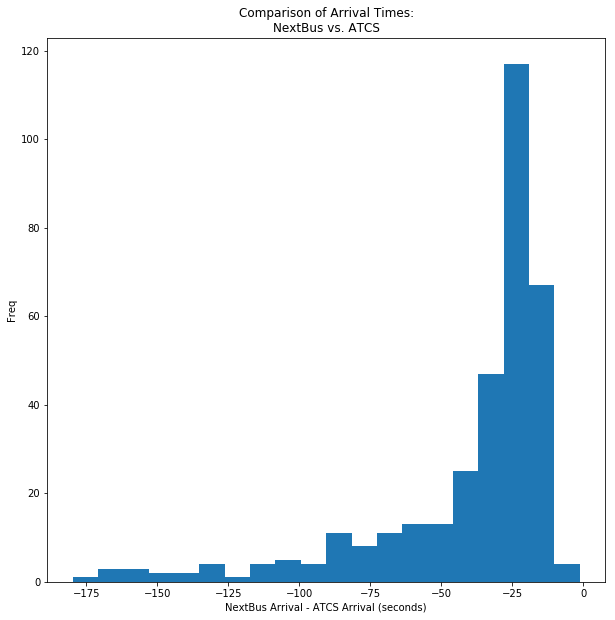

In [117]:
plt.clf()


plt.figure(figsize=(10,10))
plt.hist(matchTimeDif, bins=20)

plt.xlabel("NextBus Arrival - ATCS Arrival (seconds)")
plt.ylabel("Freq")
plt.title("Comparison of Arrival Times:\nNextBus vs. ATCS")

plt.show()

In [119]:
# NextBus Arrival Timestamp - ATCS observed Timestamp

# ATCS was always after the NextBus value

# the median number of seconds after a NB value the ATCS arrival would occur is 26.8 seconds.


pd.Series(matchTimeDif, name="Seconds").describe()

count    345.000000
mean     -39.966917
std       33.025794
min     -179.893535
25%      -44.629683
50%      -26.832204
75%      -20.160515
max       -1.260194
Name: Seconds, dtype: float64

### 6. Match ATCS to NextBus

Taking the remaining vehicles that were not matched in the first step, NextBus to ATCS, run the matcher backwards and try to 

In [112]:
# iterate through remaining unmatched ATCS observations
for j in unmatchedATCSarrivals.index:
    
    # attributes of the unmatched ATCS observation
    arrivalUnix = unmatchedATCSarrivals.loc[j, "UNIX"]
    four_digit_consist = unmatchedATCSarrivals.loc[j, "FOUR_DIGIT_CONSIST"]
    second_consist = unmatchedATCSarrivals.loc[j, "SECOND_CONSIST"]
    
    # assign line information to the unmatched ATCS observation
    subsetLines = signs2consists[(signs2consists["CONSIST"].isin([four_digit_consist, second_consist])) & (signs2consists["UNIX"] <= arrivalUnix) & (signs2consists["UNIX"] >= (arrivalUnix - (60*60)))].sort_values("UNIX")
    ATCSline = subsetLines.loc[subsetLines["UNIX"].idxmax(), "LINE"]
    
    if ATCSline == "T":
        ATCSline = "KT"
    else:
        pass
    
    # create a DataFrame of unmatched NextBus arrivals within the time window surrounding the the ATCS arrival
    potentialBackMatches = unmatchedNBarrivals[(unmatchedNBarrivals["Arrival Timestamp"] < (arrivalUnix + timeRadius)) & (unmatchedNBarrivals["Arrival Timestamp"] > (arrivalUnix - timeRadius))].copy(deep=True)
    potentialBackMatches["ArrivalTimeDif"] = [x - arrivalUnix for x in potentialBackMatches["Arrival Timestamp"]]
    potentialBackMatches["PercentileTimeDif"] = [stats.percentileofscore(matchTimeDif, x) for x in potentialBackMatches["ArrivalTimeDif"]]
    
    # if there is a potential match, iterate through
    if len(potentialBackMatches) != 0:
        for l in potentialBackMatches.index:
            
            # check if there is a line match
            if ATCSline == potentialBackMatches.loc[l, "Line"]:
                
                matchCodeID = 7
                matchresults = [potentialBackMatches.loc[l, "Vehicle"], toReadableTime(potentialBackMatches.loc[l, "Timestamp"]), matchCodeID, matchCodes[matchCodeID]]
                arrivalMatching = arrivalMatching.append(pd.DataFrame([matchresults], columns=arrivalMatchingCols), ignore_index=True)  

                unmatchedNBarrivals.drop(l, axis=0, inplace=True)
            else:
                pass
    else:
        pass
                
        
arrivalMatching.drop_duplicates(subset=["NextBus Vehicle ID", "NextBus Arrival Time"], keep="last", inplace=True)

### 7. Report

In [122]:
descriptiveStats = pd.DataFrame(arrivalMatching["Match Code Description"].value_counts())


reportPath = "REPORT-{}.txt".format(day2read)

f = open(reportPath, "w")

f.write("NextBus/ATCS Matching Rerport for " + day2read + "\n")
f.write("For support, contact Transit Technology Group\n")
f.write("\n")
f.write("** Daily Overview for " + day2read + " **\n")
f.write("\n\n")

for i in descriptiveStats.index:
    
    count = int(descriptiveStats.loc[i, "Match Code Description"])
    pct = round(count/len(arrivalMatching),3) * 100
    
    beginning = i
    end = "{} of {} arrivals ({}%)".format(count, len(arrivalMatching), pct)
    
    summary = beginning + " " + ''.join(["-" for x in np.zeros(108-(len(beginning) + len(end)))]) + " " + end + "\n"
    
    f.write(summary)

f.write("\n\n")
f.write("Vehicle IDs listed below are considered to be un-matched. They are sorted by matching failure.\n\n")
f.write("Arrivals are shown in the following format:\n<VEHICLE ID> -- <NEXTBUS ARRIVAL PREDICTION>\n\n")

for i in list(descriptiveStats[descriptiveStats.index.isin([matchCodes[x] for x in[2,5,6,8,9,10]])].index):
    f.write("* " + i + " * \n")
    f.write(matchDescriptions[i] + "\n\n")
    for row in arrivalMatching[arrivalMatching["Match Code Description"] == i].iterrows():
        index, data = row

        vehID = data[0]
        arrivalTimestamp = data[1]
        f.write(str(vehID) + " -- " + str(arrivalTimestamp) + "\n")
    f.write("\n")

f.close()

In [123]:
len(arrivalMatching)

373

In [124]:
descriptiveStats

,Match Code Description
MATCHED ON VEHICLE ID,345
GHOST TRAIN; NO UN-MATCHED ARRIVALS,11
GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW,8
ONE REMAINING MATCH; DIFFERENT LINES,6
MATCHED TO OUT-OF-SERVICE TRAIN,1
ONE REMAINING MATCH; SAME LINE,1
MATCHED; ONE UN-MATCHED RECORD HAS SAME LINE,1
